In [617]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pythermalcomfort.models as pm
import pythermalcomfort.psychrometrics as pp

## Data import

In [618]:
df = pd.read_csv('CN_DB.csv')
print(df.columns)

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude',
       'age_group'],
      dtype='object')


In [619]:
df_city = pd.read_csv('CN_DB_CITY.csv')
df_city

,city,records,top,top_std,rh,rh_std,twb,vel,met,clo,...,tsv,tsv_std,tcv,tcv_std,tav,t_out,latitude,tsr,tn_op,p_dh
0,HainanSanya,5,24.88,1.24,70.20,4.82,20.84,0.00,0.98,0.33,...,0.60,0.89,1.60,0.89,0.42,NaN,18.25,0.80,23.38,0.00
1,GuangdongGuangzhou,997,23.88,1.08,52.94,9.58,17.40,0.10,1.00,0.86,...,-0.01,0.89,1.38,0.55,0.46,16.71,23.13,0.90,23.91,0.00
2,YunnanKunming,415,13.62,3.12,16.95,13.78,4.41,0.28,1.08,0.65,...,-1.15,1.11,1.42,0.80,0.69,NaN,24.87,0.66,16.50,0.00
3,FujianFuzhou,7,18.10,1.53,67.43,5.80,14.23,0.00,0.89,0.35,...,-0.71,0.76,1.57,0.53,0.33,NaN,26.08,0.86,19.89,0.00
4,FujianZhenjiang,2,22.90,2.26,74.50,0.71,19.55,0.00,0.90,0.31,...,-0.50,2.12,1.50,0.71,0.55,NaN,26.10,0.50,24.15,0.00
5,FujianNanping,4,17.90,1.24,60.25,10.21,13.15,0.00,0.88,0.42,...,0.00,0.00,1.00,0.00,0.32,NaN,26.64,1.00,17.90,0.00
6,HunanHengyang,1,16.90,NaN,66.00,NaN,12.90,0.00,0.90,0.66,...,-1.00,NaN,2.00,NaN,-0.10,NaN,26.89,1.00,19.40,0.00
7,HunanChangsha,1108,17.41,3.07,48.35,12.03,11.00,0.03,1.02,0.95,...,-0.40,0.75,2.82,0.69,0.41,NaN,28.23,0.89,18.40,0.00
8,SichuanZigong,23,11.03,1.30,66.52,6.75,7.56,0.00,1.00,1.59,...,-0.22,1.17,1.61,0.72,0.64,NaN,29.34,0.78,11.57,0.00
9,Lhasa,355,10.64,4.03,71.19,20.88,7.66,0.02,1.10,1.25,...,-1.10,1.13,NaN,NaN,NaN,NaN,29.65,0.64,13.38,0.01


Calcualte the distance of each city to Huai River (33˚N)

In [620]:
df_city['distance'] = df_city['latitude'] - 34

## Sharp Threshold Assumption
All cities have disctrict heating systems if the distance is >= 0</br>
No city has disctrict heating systems if the distance is < 0

In [621]:
# create a new dummy variable based on the distance
df_rd = df_city.assign(threshold=(df_city["distance"] > 0).astype(int))

## Effect of Policy (Z) on Thermal Conditions (X)
Difference between the treatment and control group near the Huai river, which can be viewed as the nature experiment outcome

### Operative Temperature - Yes Mean

In [622]:
model = smf.wls("top~distance*threshold", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.4482,1.657,9.927,0.000,13.059,19.837
distance,-0.3923,0.272,-1.444,0.160,-0.948,0.164
threshold,4.9102,2.022,2.428,0.022,0.774,9.046
distance:threshold,0.5007,0.310,1.617,0.117,-0.132,1.134


The coef of the "threshold" is the causal effect, and coef of "Intercept" is the basedline </br>
The causal effect is 4.9 C, pvalue is 0.02, 95%CI is [0.8, 9.0] </br>
The district heating policy causes indoor top increases from 16.4 to 21.3

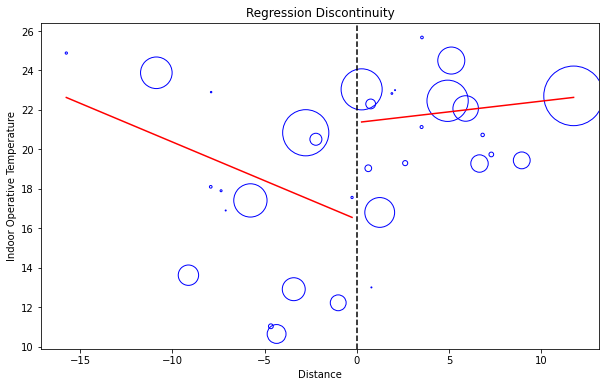

In [623]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['top'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
# plot a vertical dash line at the threshold
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Indoor Operative Temperature')
plt.title("Regression Discontinuity")
plt.show()


### Operative Temperature - Yes SD

In [624]:
model = smf.wls("top_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     5.1169
Effect is:    -2.0135
pvalue is:  0.000


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1169,0.352,14.553,0.000,4.394,5.840
distance,0.3354,0.058,5.816,0.000,0.217,0.454
threshold,-2.0135,0.429,-4.692,0.000,-2.896,-1.131
distance:threshold,-0.3854,0.066,-5.866,0.000,-0.520,-0.250


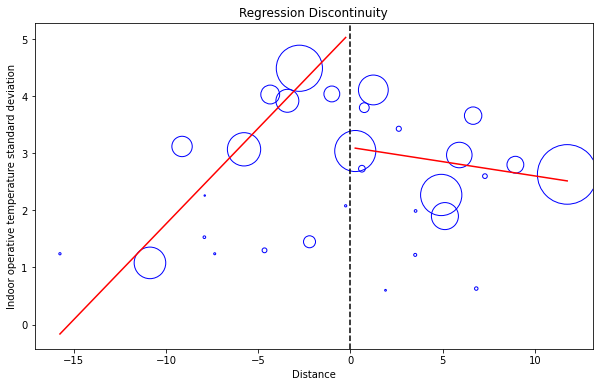

In [625]:
plt.figure(figsize=(10, 6))
# remove nanvalues of top_std in df_rd
df_rd = df_rd.dropna(subset=['top_std'])
plt.scatter(df_rd['distance'], df_rd['top_std'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Indoor operative temperature standard deviation')
plt.title("Regression Discontinuity")
plt.show()

In [626]:
# plt.figure(figsize=(10, 6))
# SE = df_rd['top_std'] / np.sqrt(df_rd['records'])
# plt.errorbar(df_rd['distance'], df_rd['top'], yerr=SE, fmt='o', color='b', ecolor='gray', elinewidth=3, capsize=4)
# plt.xlabel('Distance')
# plt.ylabel('Indoor operative temperature)')
# plt.title('Mean indoor operative temperature with standard error as bar')

### Relative Humdity - Yes Mean, No SD

In [627]:
model = smf.wls("rh~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    56.1940
Effect is:   -24.7888
pvalue is:  0.001


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.1940,5.242,10.720,0.000,45.419,66.969
distance,1.1168,0.860,1.299,0.205,-0.651,2.884
threshold,-24.7888,6.398,-3.874,0.001,-37.941,-11.637
distance:threshold,-0.9465,0.979,-0.966,0.343,-2.960,1.067


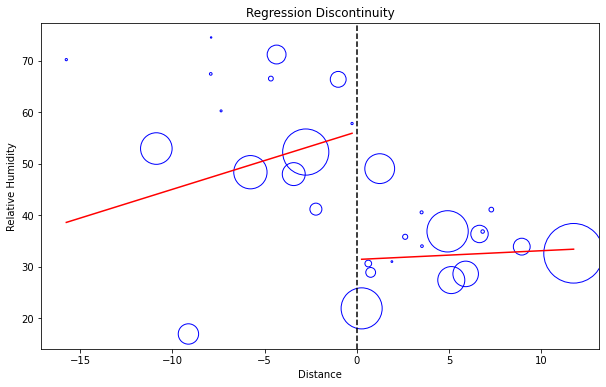

In [628]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['rh'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Relative Humidity')
plt.title("Regression Discontinuity")
plt.show()

In [629]:
#### No causal effect on standard deviation of indoor relative humidity
model = smf.wls("rh_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    14.1228
Effect is:    -0.2292
pvalue is:  0.902


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.1228,1.515,9.325,0.000,11.010,17.236
distance,0.3053,0.248,1.229,0.230,-0.205,0.816
threshold,-0.2292,1.849,-0.124,0.902,-4.029,3.571
distance:threshold,-0.6473,0.283,-2.287,0.031,-1.229,-0.066


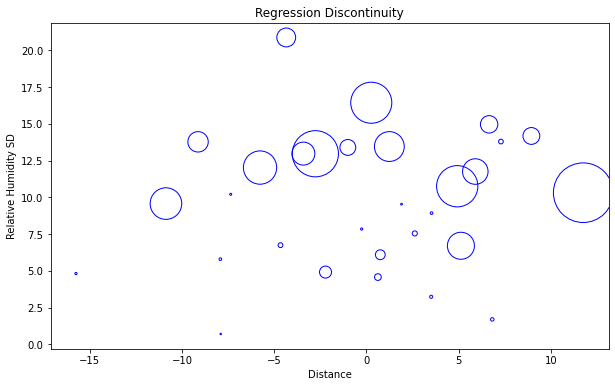

In [630]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['rh_std'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.xlabel('Distance')
plt.ylabel('Relative Humidity SD')
plt.title("Regression Discontinuity")
plt.show()

### Wet-bulb Temp - No, Why?

In [631]:
model = smf.wls("twb~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    10.9011
Effect is:     0.6250
pvalue is:  0.736


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.9011,1.504,7.250,0.000,7.810,13.992
distance,-0.2510,0.247,-1.018,0.318,-0.758,0.256
threshold,0.6250,1.835,0.341,0.736,-3.148,4.398
distance:threshold,0.4244,0.281,1.511,0.143,-0.153,1.002


### Air Velocity - No

In [525]:
model = smf.wls("vel~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.0304
pvalue is:  0.266


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0068,0.022,-0.311,0.758,-0.052,0.038
distance,-0.0132,0.004,-3.666,0.001,-0.021,-0.006
threshold,0.0304,0.027,1.136,0.266,-0.025,0.085
distance:threshold,0.0143,0.004,3.494,0.002,0.006,0.023


In [526]:
#### No causal effect on the SD of air velocity
model = smf.wls("vel_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:    -0.0480
pvalue is:  0.263


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0763,0.034,2.216,0.036,0.006,0.147
distance,0.0032,0.006,0.570,0.573,-0.008,0.015
threshold,-0.0480,0.042,-1.143,0.263,-0.134,0.038
distance:threshold,-0.0024,0.006,-0.372,0.713,-0.016,0.011


### Metabolic Rate - No

In [527]:
model = smf.wls("met~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.0129
pvalue is:  0.716


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0996,0.029,38.079,0.000,1.040,1.159
distance,0.0081,0.005,1.717,0.098,-0.002,0.018
threshold,0.0129,0.035,0.367,0.716,-0.060,0.085
distance:threshold,-0.0168,0.005,-3.105,0.005,-0.028,-0.006


### Clothing Insulation - No Mean

In [567]:
model = smf.wls("clo~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.1943
Effect is:    -0.3049
pvalue is:  0.088


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1943,0.141,8.475,0.000,0.905,1.484
distance,0.0355,0.023,1.535,0.137,-0.012,0.083
threshold,-0.3049,0.172,-1.773,0.088,-0.658,0.049
distance:threshold,-0.0316,0.026,-1.199,0.241,-0.086,0.023


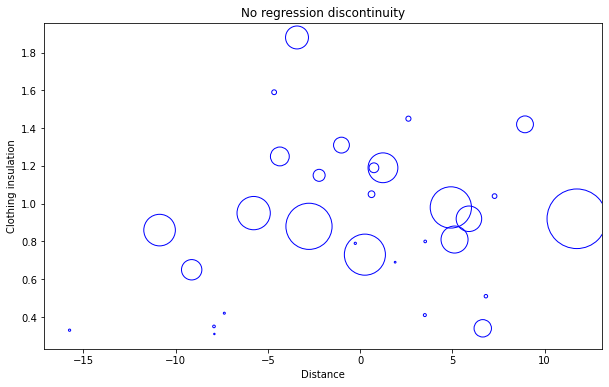

In [616]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['clo'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Clothing insulation')
plt.title("No regression discontinuity")

plt.show()

### Clothing Insulation - Yes SD

In [575]:
model = smf.wls("clo_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.5321
Effect is:    -0.1829
pvalue is:  0.001


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5321,0.042,12.762,0.000,0.446,0.618
distance,0.0278,0.007,4.064,0.000,0.014,0.042
threshold,-0.1829,0.051,-3.594,0.001,-0.288,-0.078
distance:threshold,-0.0300,0.008,-3.853,0.001,-0.046,-0.014


Text(0.5, 1.0, 'No regression discontinuity')

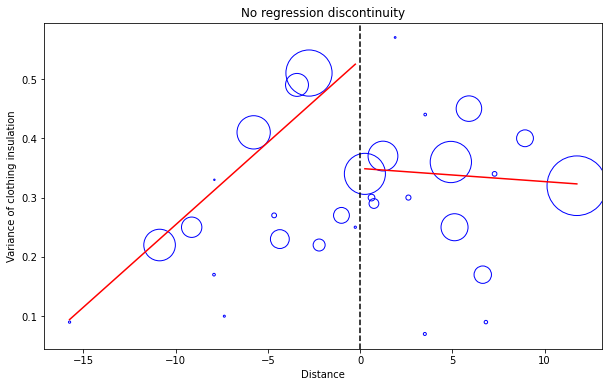

In [570]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['clo_std'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Variance of clothing insulation')
plt.title("No regression discontinuity")

In [571]:
# plt.figure(figsize=(10, 6))
# SE = df_rd['clo_std'] / np.sqrt(df_rd['records'])
# plt.errorbar(df_rd['distance'], df_rd['clo'], yerr=SE, fmt='o', color='b', ecolor='gray', elinewidth=3, capsize=4)
# plt.xlabel('Distance')
# plt.ylabel('Clothing insulation')
# plt.title('TA with standard error as bar')

### Conclusions


The policy affects mean indoor top and the variation of top </br>
The policy affects mean indoor rh </br>
The policy doesn't affect mean clo </br>
But the policy affects the variation of clo </br>

Assuming that the policy affects clothing insulation only through indoor thermal environment, represented by top and rh </br>
policy -> top & rh -> clo </br>
Then, increasing mean top or decreasing rh doesn't affect mean clo. </br>
However, reducing variation of top affect variation of clo </br>
2C delta top -> 0.2 delta clo

### Thermal Sensation Vote - Yes

In [576]:
model = smf.wls("tsv~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    -0.4039
Effect is:     0.6373
pvalue is:  0.028


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4039,0.224,-1.803,0.083,-0.864,0.057
distance,-0.0034,0.037,-0.092,0.927,-0.079,0.072
threshold,0.6373,0.273,2.330,0.028,0.075,1.199
distance:threshold,0.0036,0.042,0.086,0.932,-0.082,0.090


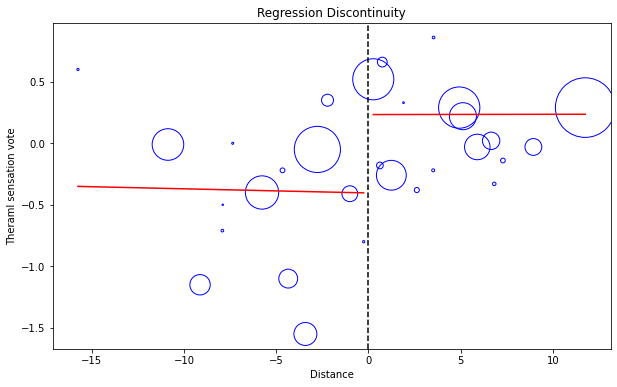

In [577]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['tsv'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Theraml sensation vote')
plt.title("Regression Discontinuity")
plt.show()

Assuming that the policy affects thermal sensations only through indoor thermal environment, represented by top and rh </br>
Which means there is no psychological effect </br>
Then, then increasing mean indoor top from 17 to 22 (5 delta) would increase thermal sensation from -0.4 to 0.2 (0.6 delta) </br>
It's hard to compare with PMV model due to the unknown clo value. Two groups have the same clo, but which values to use is unceratin. At different values, PMV have different output delta TSV. 

In [597]:
model = smf.wls("tsv_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.9645
Effect is:    -0.1010
pvalue is:  0.404


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9645,0.098,9.886,0.000,0.764,1.165
distance,0.0059,0.016,0.367,0.716,-0.027,0.039
threshold,-0.1010,0.119,-0.848,0.404,-0.346,0.144
distance:threshold,0.0076,0.018,0.419,0.679,-0.030,0.045


### Thermal Comfort Vote - No

In [595]:
model = smf.wls("tcv~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.6940
Effect is:    -0.2112
pvalue is:  0.468


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6940,0.240,7.046,0.000,1.198,2.190
distance,-0.0035,0.038,-0.093,0.927,-0.082,0.075
threshold,-0.2112,0.286,-0.738,0.468,-0.802,0.379
distance:threshold,0.0103,0.043,0.240,0.812,-0.078,0.099


In [596]:
model = smf.wls("tcv_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.6135
Effect is:     0.0092
pvalue is:  0.902


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6135,0.062,9.885,0.000,0.485,0.742
distance,-0.0021,0.010,-0.217,0.830,-0.022,0.018
threshold,0.0092,0.074,0.125,0.902,-0.143,0.162
distance:threshold,0.0083,0.011,0.754,0.458,-0.014,0.031


### Thermal Satisfaction Rate - No

In [598]:
model = smf.wls("tsr~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.8135
Effect is:     0.0392
pvalue is:  0.610


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8135,0.062,13.100,0.000,0.686,0.941
distance,-0.0028,0.010,-0.272,0.787,-0.024,0.018
threshold,0.0392,0.076,0.517,0.610,-0.117,0.195
distance:threshold,0.0017,0.012,0.149,0.883,-0.022,0.026


### Thermal Acceptablity Vote - No

In [615]:
model = smf.wls("tav~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.2778
Effect is:    -0.0776
pvalue is:  0.489


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2778,0.089,3.109,0.005,0.093,0.463
distance,-0.0219,0.014,-1.548,0.135,-0.051,0.007
threshold,-0.0776,0.110,-0.703,0.489,-0.306,0.151
distance:threshold,0.0680,0.016,4.203,0.000,0.035,0.101


## Effect of P on Neutral Temperature (tricky)


In [383]:
# needs one more non-NaN neutral temperature/comfort zone calcualted by regression approach a and b
# neutral temperature calcualted by Griffth method, and using measured globe temperature
model = smf.wls("tn_op~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Causal effect is:", model.summary().tables[1][3][1])
print("p-value is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Causal effect is:     2.8191
p-value is:  0.057


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.8377,1.058,16.857,0.000,15.674,20.002
distance,-0.3848,0.201,-1.916,0.065,-0.795,0.026
threshold,2.8191,1.420,1.985,0.057,-0.085,5.723
distance:threshold,0.4924,0.229,2.154,0.040,0.025,0.960


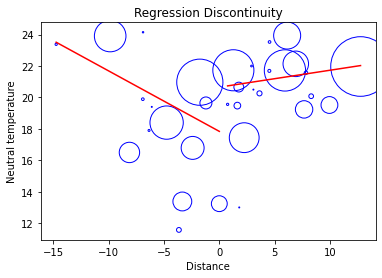

In [384]:
# scatter plot tn_op vs distance
plt.scatter(df_rd['distance'], df_rd['tn_op'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Neutral temperature')
plt.title("Regression Discontinuity")
plt.show()

Assuming that the policy can only affect the neutral temperature through indoor thermal enviornment, represented by the tg. Then the causal effect of indoor globe temperature on neutral temperature is 4.6279/5.2973 = 0.87 (95% CI:0.64, 0.92)

## Effect of X on Comfort Vote
The assumption is that the district heating policy affects Y only through indoor thermal environment, represented by  </br>

P -> X -> Y

## Fuzzy Threshold Assumption
All cities have disctrict heating systems if the distance is > 2
No city has disctrict heating systems if the distance is < -2